## Import all of used library 
is needed to run all of the cells in this section

In [ ]:
# Import library that needed for colab
from google.colab import drive # colab only
from google.colab import files # colab only

# To remove all warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import zipfile
import pandas as pd
import requests
import random
import calendar
import time

from PIL import Image

from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive
from shutil import rmtree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from tensorflow import lite, cast, float32
from tensorflow import saved_model

from imblearn.over_sampling import RandomOverSampler 

In [ ]:
# To mounting Google Drive

def google_drive_mount(mounting=False):
  if mounting:
    drive.mount('/content/drive')

In [ ]:
# Download the file

def download_file(urls, unzip=True, remove_after_unzip=False, google_drive=False, filename='tmp', ext='zip'):

  url = urls
  CHUNK_SIZE = 32768
  file_tmp = f'{filename}.{ext}'

  # If Downloading from Google Drive
  if google_drive:

    # Get the token
    def get_confirm_token(response):
      
      for key, value in response.cookies.items():
        if key.startswith('download_warning'):
          return value
      return None
    
    url_raw = 'https://docs.google.com/uc?export=download'
    file_id = url.split('/')[-2] # Split the file id
    session = requests.Session() # Get session
    response = session.get(url_raw, params={'id': file_id}, stream=True) # Get the response
    token = get_confirm_token(response) # Get the token

    # If there is token
    if token:
      response = session.get(url_raw, params={'id': file_id, 'confirm': token}, stream=True) # Get the response
    
    # Save the response as zip file
    with open(file_tmp, 'wb') as f:
      for chunk in response.iter_content(CHUNK_SIZE):
        if chunk:
          f.write(chunk)
  
  # If not from Google Drive
  else:
    filedata = get_file(origin=url, fname=os.path.join(os.getcwd(), file_tmp)) # Get the response from URL

  # Extract the zip files
  if unzip:
    local_zip = file_tmp
    zip_ref = zipfile.ZipFile(local_zip, 'r') # Extract 
    zip_ref.extractall(f'{os.getcwd()}/') # Extract
    zip_ref.close()
    # Remove the zip file after unzip
    if remove_after_unzip:
      os.remove(file_tmp)  
  
  # If not a zip file
  else:
    return file_tmp

In [ ]:
# Load the saved models/checkpoints models from Google Drive

def load_models(url, summary=False, filenames='tmp'):
  model_download = download_file(url, unzip=False, remove_after_unzip=True, google_drive=True, ext="h5", filename=filenames)  
  model = load_model(model_download)
  if summary:
    model.summary()
  return model

In [ ]:
class_names = ['BKL','NV','MEL']

class_names_long = ['Benign keratosis-like lesions', 'Melanocytic nevi', 'Melanoma']

## Converting the datasets
Purpose for this section is to Converting the datasets into smaller and more memory friendly format
This section has already ran, so no need to run all of the cells again.

Resizing the datasets into small size and rearranging to make training more faster, <br>
Source datasets: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [ ]:
google_drive_mount(mounting=True)

Mounted at /content/drive


In [ ]:
# Upload the *.json file to the colab, *.json file is for auth to kaggle 
# You need an auth *.json files from your kaggle account
# To download the files through the API
files.upload() 

# install some requirements for kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

# Source: https://www.kaggle.com/general/74235

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
# Change directory to Google Drive
if not os.path.exists("/content/drive/MyDrive/fix-datasets-new"):
  os.mkdir("/content/drive/MyDrive/fix-datasets-new")

os.chdir("/content/drive/MyDrive/fix-datasets-new")

if not os.path.exists(f'{os.getcwd()}/skin-cancer-mnist-ham10000'):
  os.mkdir(f'{os.getcwd()}/skin-cancer-mnist-ham10000') # Make directory for MNIST HAM 10000 

os.chdir(f'{os.getcwd()}/skin-cancer-mnist-ham10000') # Change directory to MNIST HAM 10000 

In [ ]:
# Downloading the datasets using Kaggle API
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:49<00:00, 81.0MB/s]
100% 5.20G/5.20G [01:53<00:00, 49.0MB/s]


In [ ]:
# Extracting the datasets
local_zip = f'{os.getcwd()}/skin-cancer-mnist-ham10000.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f'{os.getcwd()}/')
zip_ref.close()

# Removing the old 'huge' zip
os.remove(f'{os.getcwd()}/skin-cancer-mnist-ham10000.zip')

In [ ]:
# Resizing and moving function
def resize_img(SOURCE, DEST, SIZE=299):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  print(len(files))
  for filename in files:
    if '.jpg' in filename:
      img = cv2.imread(f"{SOURCE}{filename}")
      resize_img = cv2.resize(img, (SIZE,SIZE))
      cv2.imwrite(f"{SOURCE}/{filename}", resize_img)
      move(f"{SOURCE}/{filename}",f"{DEST}/{filename}")

os.mkdir(f'{os.getcwd()}/HAM10000') # Because file in zip is separate by 2 parts, 
                                    # so we create new directory to save all parts
                                    # in one folder to make resizing more easy

# Resizing the image
resize_img(f'{os.getcwd()}/HAM10000_images_part_1/',f'{os.getcwd()}/HAM10000/')
resize_img(f'{os.getcwd()}/HAM10000_images_part_2/',f'{os.getcwd()}/HAM10000/')
resize_img(f'{os.getcwd()}/ham10000_images_part_1/',f'{os.getcwd()}/HAM10000/')
resize_img(f'{os.getcwd()}/ham10000_images_part_2/',f'{os.getcwd()}/HAM10000/')

# Remove some dir, to make directory more clean
os.rmdir(f'{os.getcwd()}/HAM10000_images_part_1')
os.rmdir(f'{os.getcwd()}/HAM10000_images_part_2')
os.rmdir(f'{os.getcwd()}/ham10000_images_part_1')
os.rmdir(f'{os.getcwd()}/ham10000_images_part_2')

# Checking how much file in HAM10000 to make sure there is no file lost
print(len(os.listdir(f'{os.getcwd()}/HAM10000'))) # 10015

5000
5015
5000
5015
10015


In [ ]:
# Converting lesion type to more readable format
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Reading the csv file
df = pd.read_csv(f'{os.getcwd()}/HAM10000_metadata.csv')

# Adding more columns in csv
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 

# Because too many Melanocytic Nevi pictures, so we pick randomly only 1205 samples
df_random = df[df['cell_type'] == 'Melanocytic nevi'].sample(n=1205, random_state=1)
df = df.drop(df[df['cell_type']== 'Melanocytic nevi'].index)
df = df.drop(df[df['cell_type']== 'Dermatofibroma'].index) # Removing the Dermatofibroma class
df = df.drop(df[df['cell_type']== 'Vascular lesions'].index) # Removing the Vascular lesion class
df = df.drop(df[df['cell_type']== 'Basal cell carcinoma'].index) # Removing the Vascular lesion class
df = df.drop(df[df['cell_type']== 'Actinic keratoses'].index) # Removing the Vascular lesion class
df = df.append(df_random)


# One hot encoding datasets
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

# Writing new metadata.csv
df.to_csv(f'{os.getcwd()}/metadata.csv')

# Then delete unnecessary files on HAM10000 then moved to HAM10000-fix
df_read = pd.read_csv(f'{os.getcwd()}/metadata.csv')
os.mkdir(f'{os.getcwd()}/data')
for i in range(len(df_read)):
  move(f"{os.getcwd()}/HAM10000/{df_read['image_id'].values[i]}.jpg", f"{os.getcwd()}/data/{df_read['image_id'].values[i]}.jpg")

# Then delete unnecessary files
rmtree(f'{os.getcwd()}/HAM10000/')
os.remove(f'{os.getcwd()}/hmnist_28_28_L.csv')
os.remove(f'{os.getcwd()}/hmnist_28_28_RGB.csv')
os.remove(f'{os.getcwd()}/hmnist_8_8_L.csv')
os.remove(f'{os.getcwd()}/hmnist_8_8_RGB.csv')

In [ ]:
df['cell_type'].value_counts()

Melanocytic nevi                 1205
Melanoma                         1113
Benign keratosis-like lesions    1099
Name: cell_type, dtype: int64

In [ ]:
os.chdir('/content/drive/MyDrive/fix-datasets-new/')
make_archive('ham10000-fix-3class', 'zip', '/content/drive/MyDrive/fix-datasets-new/skin-cancer-mnist-ham10000/') # Create the new zip file

'/content/drive/MyDrive/fix-datasets-new/ham10000-fix-3class.zip'

We successfully resizing the file from 5 GB to only 90 MB.
After that, we host the zip file to Google Drive <br> here is the links: https://drive.google.com/file/d/127GzJ-ymLp6GJ-SBGRIQ6O0UMFU0hciU/view?usp=sharing

## Analysis and pre-processing the datasets
Analysis and pre-processing the new converted datasets above


In [ ]:
download_file('https://drive.google.com/file/d/127GzJ-ymLp6GJ-SBGRIQ6O0UMFU0hciU/view?usp=sharing', remove_after_unzip=True, google_drive=True)

# Checking the downloaded file
len(os.listdir('data'))

In [ ]:
def define_dataset(csv, unique=False, show_df = False):

  df = pd.read_csv(csv) # Reading the csv files from pandas
  img = df['image_id'] # Define the Feature 
  target = df['cell_type_idx'].values # Define the Labels
  df_unique = df['cell_type'].value_counts() # Amout of unique value

  if unique: # Counting unique values
    return img, target, df_unique
  
  if show_df:
    return img, target, df
  
  else:
    return img, target

In [ ]:
# Defining dataset into labels and features
img, target, df_unique = define_dataset('metadata.csv', unique=True)

In [ ]:
df_unique

Melanocytic nevi                 1205
Melanoma                         1113
Benign keratosis-like lesions    1099
Name: cell_type, dtype: int64

In [ ]:
def split_data(x, y, test_size=0.2, validation_size=0.05, balancing=False):
  
  # Balancing the datasets, if the datasets not balanced so this function will balanced them
  def balancing_dataset(x_train, x_val, y_train, y_val):
    
    # Balancing with OverSampler method from Imbalanced Learn
    # Source: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
    oversample = RandomOverSampler()
    x_train, y_train  = oversample.fit_resample(x_train.values.reshape(-1,1),y_train)
    x_val, y_val  = oversample.fit_resample(x_val.values.reshape(-1,1),y_val)
    
    return x_train, x_val, y_train, y_val
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_size)

  # If balancing is True, so the datasets will be balancing
  if balancing:
    x_train, x_val, y_train, y_val = balancing_dataset(x_train, x_val, y_train, y_val)
  
  # Print the results of splitting
  print("Train: ", x_train.shape[0]), print("Val: ", x_val.shape[0]), print("Test: ", x_test.shape[0]), 
  
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
# Splitting into train, valid and test with balancing all of the data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(img, target, balancing=True, test_size=0.2, validation_size=0.2)

Train:  2925
Val:  690
Test:  684


In [ ]:
def to_tensor(image_paths, oversample=True, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    if oversample: # If datasets is balanced
      img = load_img(f"data/{i[0]}.jpg", target_size=(size, size)) # Load the Image then resized them
    else:
      img = load_img(f"data/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs

In [ ]:
# We only balanced the Train and Validation data
# So, if we set oversample to True for x_test
# There will be errors
x_train = to_tensor(x_train, size=299)
x_val = to_tensor(x_val, size=299)
# x_test = to_tensor(x_test)

# Unbalanced datasets
#x_train = to_tensor(x_train, oversample=False)
#x_val = to_tensor(x_val, oversample=False)
x_test = to_tensor(x_test, oversample=False, size=299) # Since this is only the test dataset, no need to balanced this

100%|██████████| 684/684 [00:01<00:00, 373.58it/s]


In [ ]:
def show_batch(x, y, figsize=12, subfigsize=5, n=25, no_axis=True):

  plt.figure(figsize=(figsize, figsize)) # Defining figure of the datasets
  
  for i in range(n): # Iterating through n datasets randomly
      ax = plt.subplot(subfigsize, subfigsize, i+1) # Defining frontend of figure
      plt.imshow(x[i]) # Showing the picture from datasets
      plt.title(class_names[y[i]]) # Showing class names
      
      # Remove axis from the figure
      if no_axis:
        plt.axis('off')

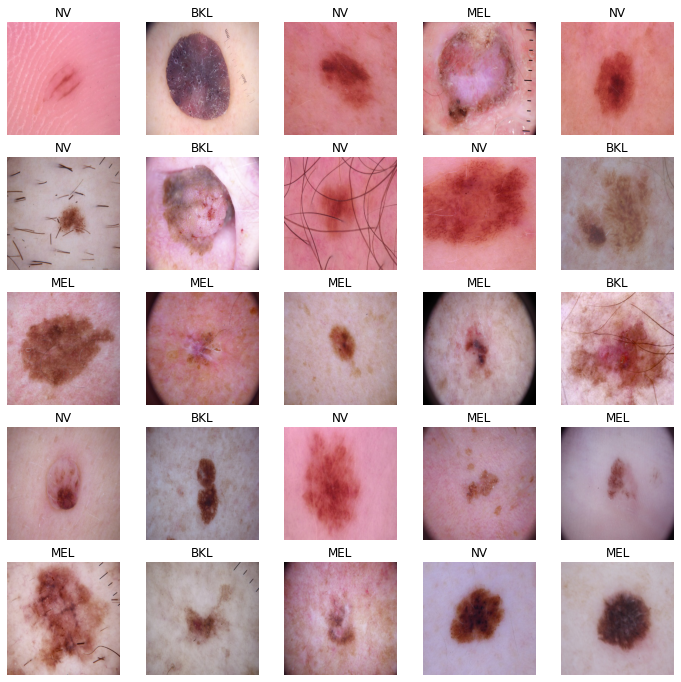

In [ ]:
# Showing images from the datasets
show_batch(x_test, y_test)

## Defining the models and training the datasets
Defining the models and train the datasets based from the models that have been adjusted

In [ ]:
# Prediction the test datasets portion

def predictions(model, x_test, y_test, accuracy=True, axis=1):
  
  predictions = model.predict(x_test) # Predict the test datasets
  pred = np.argmax(predictions, axis=axis) # Showing the greatest value from predictions (range: 0-1, biggest is 1)
  
  # Printing the accuracy, with comparing predictions with labels of test datasets portion
  if accuracy: 
    print("\nAccuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))
  
  return pred, x_test, y_test

In [ ]:
# Defining the models

def trainable_model(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, 
                    fine_tuning=False, dropout=0.25, base_model='MobileNet', 
                    regularizer=0.01, learning_rate=1e-4, epochs=15, verbose=1, 
                    metrics='accuracy', pool_size=2, rotation_range=30, 
                    zoom_range=0.15, width_shift_range=0.2, shear_range=0.15, 
                    horizontal_flip=True, fill_mode="nearest", height_shift_range=0.2,
                    weights="imagenet", include_top=False, summary=False, 
                    valid_generator=False, callbacks=None, generator=True,
                    checkpoint=None):
  
  dataset = (x_train, y_train, x_val, y_val)

  BATCH_SIZE = batch_size
  INPUT_SHAPE = dataset[0][0].shape
  trainX = dataset[0]
  trainY = dataset[1]
  valX = dataset[2]
  valY = dataset[3]

  generators = ImageDataGenerator()
  train_dataset = generators.flow(trainX, trainY, batch_size=BATCH_SIZE)
  valid_dataset = generators.flow(valX, valY, batch_size=BATCH_SIZE)

  if generator:
    train_gen = ImageDataGenerator(rotation_range=rotation_range,
                                  zoom_range=zoom_range,
                                  width_shift_range=width_shift_range,
                                  height_shift_range=height_shift_range,
                                  shear_range=shear_range,
                                  horizontal_flip=horizontal_flip,
                                  fill_mode=fill_mode)

    train_dataset = train_gen.flow(trainX, trainY, batch_size=BATCH_SIZE)
    
    if valid_generator:
      valid_dataset = train_gen.flow(valX, valY, batch_size=BATCH_SIZE)
  
  if base_model in ['MobileNet','MobileNetV1']:
    base_model = MobileNet(weights=weights, 
                           include_top=include_top, 
                           input_tensor=Input(shape=INPUT_SHAPE)) # MobileNet: 83%, Epochs: 7

  elif base_model is 'MobileNetV2':
    base_model = MobileNetV2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # MobileNetV2: 75%, Epochs: 8

  elif base_model is 'VGG16':
    base_model = VGG16(weights=weights, 
                       include_top=include_top, 
                       input_tensor=Input(shape=INPUT_SHAPE)) # VGG16: 90%, Epochs: 7
  
  elif base_model in ['EfficientNetB0','EfficientNet']:
    base_model = EfficientNetB0(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # EfficientNetB0: 66%, Epochs: 6

  elif base_model is 'InceptionV3':
    base_model = InceptionV3(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Doesn't support by this dataset

  elif base_model is 'VGG19':
     base_model = VGG19(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # VGG19, 83%, Epochs: 10

  elif base_model is 'Xception':
    base_model = Xception(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Xception: 95%, Epochs: 9     

  elif base_model is 'DenseNet121':
    base_model = DenseNet121(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  elif base_model is 'DenseNet201':
    base_model = DenseNet201(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # DenseNet201: 82% Epochs: 6

  elif base_model is 'ResNet152V2':
    base_model = ResNet152V2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # ResNet152V2: 75%, Epochs: 6

  elif base_model is 'EfficientNetB5':
    base_model = EfficientNetB5(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this

  base_model.trainable=False

  if fine_tuning:
    base_model.trainable=True
    
  model = Sequential([base_model, 
                      AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                      Flatten(), 
                      Dense(64, activation='relu'),
                      Dropout(dropout), 
                      Dense(16, activation='relu'),
                      Dense(3, activation='softmax', kernel_regularizer=l2(regularizer)),
  ])

  model.compile(optimizer=Adam(lr=learning_rate), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=[metrics])

  if summary:
    model.summary()
  
  history = model.fit(train_dataset, 
                      epochs=epochs, 
                      validation_data=valid_dataset, 
                      verbose=verbose,
                      callbacks=[callbacks, checkpoint])
  
  _ = predictions(model, x_test, y_test)

  return history, model

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

checkpoints = ModelCheckpoint('HAM10000_Xception_dropout0045_' + "{accuracy:.2f}acc.h5", verbose=1)

history, model = trainable_model(x_train, y_train, x_val, y_val, x_test, y_test,
                                 fine_tuning=True, epochs=20, base_model='Xception', 
                                 dropout=0.05, regularizer=0.1, batch_size=32,
                                 callbacks=callbacks, summary=True, checkpoint=checkpoints)

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
average_pooling2d (AveragePo (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3276864   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________

In [ ]:
# Save the models to Google Drive

google_drive_mount(mounting=True)
copy("/content/HAM10000_Xception_dropout0045_0.97acc0.h5", "/content/drive/MyDrive/fix-datasets")

# Saved it to google drive: https://drive.google.com/file/d/16U54U2sCJQCQtLuhFGKLX_rzQ9cQLv94/view?usp=sharing <- here is the links (for 64x64 models)

Mounted at /content/drive


'/content/drive/MyDrive/fix-datasets/HAM10000_Xception_dropout0045_0.97acc0.h5'

## Loading the datasets and testing the datasets
Load the checkpoint model (with keras *.h5 format) and testing with testing portion on the datasets

In [ ]:
links = 'https://drive.google.com/file/d/16U54U2sCJQCQtLuhFGKLX_rzQ9cQLv94/view?usp=sharing'
model = load_models(links)

In [ ]:
# Scoring saved models/checkpoint models

def scoring(model, x_test, y_test, verbose=0, returning='confusion_matrix'):

  
  score = model.evaluate(x_test, y_test, verbose=verbose)
  predicting = model.predict(x_test)
  pred = np.argmax(predicting, axis=1)
  conf = confusion_matrix(y_test, pred)  
  
  if returning in ['score', 'scoring']:
    return score
  
  if returning in ['predicting', 'pred', 'predict']:
    return pred

  if returning in ['conf', 'confusion_matrix', 'confussion', 
                   'confusion', 'conf_mat', 'confusion_mat']:
    return conf

In [ ]:
score = scoring(model, x_test, y_test, returning='score')
confusion_mat = scoring(model, x_test, y_test, returning='confusion_mat')

In [ ]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 95.03%


In [ ]:
def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
  fig, ax = plt.subplots(figsize=(10,10))
  
  sn.heatmap(confusion_mat, annot=True, fmt='.2f',
            xticklabels=[f"{c}" for c in class_names], 
            yticklabels=[f"{c}" for c in class_names],
            cmap=cmap)
  
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

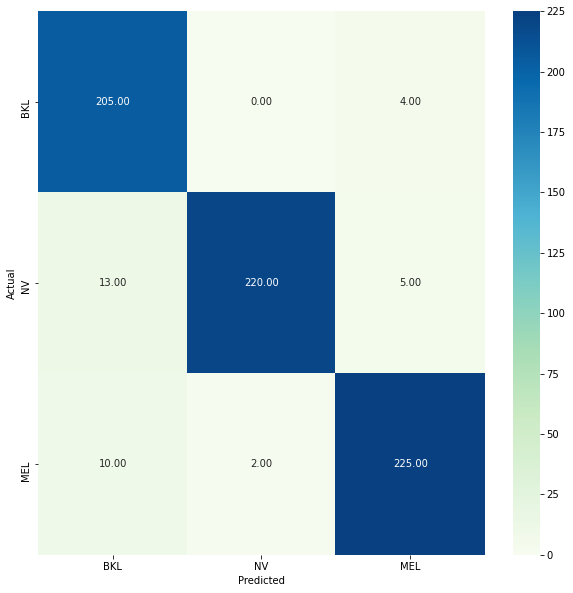

In [ ]:
plot_confusionmat(confusion_mat, class_names)

In [ ]:
# test some picture here

# this is for general testing

imgs = []

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  
  plt.imshow(load_img(path, target_size=(150, 150)))
  plt.show()
  
  img = load_img(path, target_size=(150, 150))
  img = img_to_array(img)
  img = img.astype(np.float32) / 255
  imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}")
if class_names_long[pred[0]] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

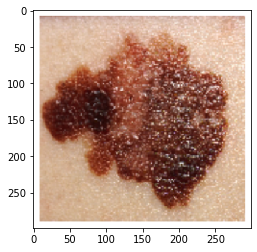


Predicting: 70.23% of Benign keratosis-like lesions
Kind of Cancer: Benign
Benign means it is not a dangerous cancer or not a cancer


In [ ]:
# test some picture here
# Model 3

imgs = []

path = 'download.png'
  
plt.imshow(load_img(path, target_size=(299, 299)))
plt.show()
  
img = load_img(path, target_size=(299, 299))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

## Convert Keras Model to Tensorflow SavedModel (Optional)
Purposed in this section to convert checkpoint model (keras *.h5 format) to SavedModel Tensorflow format, in order you want to deploy it to web or Google Cloud or something that needed Tensorflow SavedModel

In [ ]:
def KerastoSavedModel(links, mounting=False, make_archive=False, move_to_drive=True):

    # Mount Google Drive
    google_drive_mount(mounting=mounting)

    # Load model from Keras
    model = load_models(links)

    # Convert it to SavedModel
    if mounting:
        saved_model.save(model, '/content/drive/MyDrive/fix-datasets/models')

    else:
        saved_model.save(model, '/content/models')

    if make_archive:
        # Store it on zip files
        if mounting:
            make_archive('models', 'zip', '/content/drive/MyDrive/fix-datasets/models') # Create the new zip file

        else:
            make_archive('models', 'zip', '/content/models') # Create the new zip file

    if move_to_drive:
        # Move it to drive
        move('/content/models.zip', '/content/drive/MyDrive/fix-datasets/')

In [ ]:
links = 'https://drive.google.com/file/d/1-4HGDErWwQbvMERzcOWU8RSvN9Y7xxqu/view?usp=sharing'
KerastoSavedModel(links, mounting=True, make_archive=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/fix-datasets/models/assets


'/content/models.zip'

Load the models from above (Google Drive): https://drive.google.com/file/d/1-UCuB8mIvQNST7sTFmEiwN3DLeJRq2qw/view?usp=sharing

In [ ]:
# Just run this cell, because SavedModel has been hosted in Google Drive
# Download the models from Google Drive: https://drive.google.com/file/d/1-UCuB8mIvQNST7sTFmEiwN3DLeJRq2qw/view?usp=sharing
# Then load the models
path_to_models = '/content/models'

if not os.path.exists(path_to_models):
    os.mkdir(path_to_models)

os.chdir(path_to_models)

download_file('https://drive.google.com/file/d/1-UCuB8mIvQNST7sTFmEiwN3DLeJRq2qw/view?usp=sharing', remove_after_unzip=True, google_drive=True)

model = load_model(path_to_models)

For testing purposed

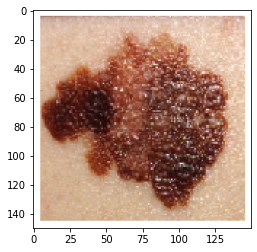


Predicting: 89.59% of Melanoma
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


In [ ]:
# test some picture here

imgs = []

path = 'download.png'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

## Load it to Tensorflow-lite (Optional)
Purposed in this section to convert checkpoint model (keras *.h5 format) to Tensorflow lite format, in order you want to deploy it to web, embedded, mobile or microcontroller devices

In [ ]:
def to_tflite(links, tflite_filename = 'converted_model.tflite', optimizations='size'):
    
    model = load_models(links)
    converter = lite.TFLiteConverter.from_keras_model(model)
    
    if optimizations in ['size', 'SIZE']:
        converter.optimizations = [lite.Optimize.OPTIMIZE_FOR_SIZE]
    
    if optimizations in ['latency', 'LATENCY']:
        converter.optimizations = [lite.Optimize.OPTIMIZE_FOR_LATENCY]
    
    tflite_model = converter.convert()
    
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)
    
    return tflite_filename

In [ ]:
links = 'https://drive.google.com/file/d/1-4HGDErWwQbvMERzcOWU8RSvN9Y7xxqu/view?usp=sharing' # Load Keras Models or SavedModel
tflite_filename = to_tflite(links)

INFO:tensorflow:Assets written to: /tmp/tmp5wtsyo22/assets


For testing the converted models

In [ ]:
# Assign labels
labels = []
for i in class_names_long:
    labels.append(i)

# Load lite model
interpreter = lite.Interpreter(tflite_filename)
interpreter.allocate_tensors()

# Get I/O details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load image
img = Image.open('download.png').convert('RGB')

# Show image
#plt.imshow(img)
#plt.show()
#print(" ")

# Get input size
input_shape = input_details[0]['shape']
size = input_shape[:2] if len(input_shape) == 3 else input_shape[1:3]

# Preprocess image
img = img.resize(size)
img = np.array(img)
img = img.astype(np.float32) / 255
img = np.expand_dims(img, axis=0)

# Run the interpreter
interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()

# The predictions
predictions = interpreter.get_tensor(output_details[0]['index'])[0]
pred = np.argmax(predictions)

# The results
print(f'Predicting {predictions[pred]*100:.2f}% of {labels[pred]}')
if labels[pred] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

Predicting 94.37% of Melanoma
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer
